Step 1: download the data from eotdl

In [ ]:
import os
import zipfile
import eotdl
from eotdl.datasets import download_dataset

download_dataset("EuroSAT", version=1, path="data", force=True)

os.makedirs("data/EuroSAT", exist_ok=True)

with zipfile.ZipFile("data/EuroSAT/v1/EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall("data/EuroSAT")

Step 2: Make a random selection of labelled data for which we want to extract EO data, from the images we can readily extract their geospatial bounding box. We append this information into a dataframe which will lateron be used to orchestrate the EO data extraction.

In [11]:
from dataframe_utils import *

# Constants
src_dir = r"C:\Git_projects\eotdl_wip\data\EuroSAT\ds\images\remote_sensing"
num_files = 10 #number of images we wish to process

start_date = "2020-01-01"
nb_months = 3

distance_m = 320  # Buffer distance in meters
resolution = 20.0  # Grid resolution in meters

tif_files = get_tif_files(src_dir)
selected_files = random.sample(tif_files, num_files)

base_df = generate_geodataframe_from_files(selected_files, start_date, nb_months, distance_m, resolution)

split_df = prepare_split_jobs(base_df, 10)
job_df = create_job_dataframe_s2(split_df)
job_df






c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\eotdl_openeo_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:80: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["centroid"] = polygons.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\eotdl_openeo_env\lib\site-packages\openeo_gfmap\manager\job_splitters.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  s2_grid["geometry"] = s2_grid.geometry.centroid
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\eotdl_openeo_env\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before t

,temporal_extent,geometry,s2_tile,h3index
0,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",30SUF,833918fffffffff
1,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",30UWE,831955fffffffff
2,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",31UCP,831fb6fffffffff
3,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",32TPT,831f88fffffffff
4,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",32UNF,831f06fffffffff
5,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",33UUV,831f03fffffffff
6,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",34TFK,831edefffffffff
7,"[2020-01-01, 2020-04-01]","{""type"": ""FeatureCollection"", ""features"": [{""i...",34UCF,831f09fffffffff


In [ ]:
from s3proxy_utils import upload_geoparquet_file
import openeo
#TODO I think we can use the job_df to run multiple jobs.
# for each row, we create a seperate geodataframe and send it as a parquet which is then used as a spatial filter
# in a UDP 
#from the jobs dataframe we derive a geodataframe which only contains the geometries

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
geo_df =  create_geodataframe(job_df)
url = upload_geoparquet_file(geo_df,connection)


Authenticated using refresh token.


In [ ]:
from openeo.extra.job_management import MultiBackendJobManager, CsvJobDatabase

# Authenticate and add the backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

# initialize the job manager
manager = MultiBackendJobManager()
manager.add_backend("cdse", connection=connection, parallel_jobs=2)

job_tracker = 'job_tracker.csv'
job_db = CsvJobDatabase(path=job_tracker)
if not job_db.exists():
    df = manager._normalize_df(job_df)
    job_db.persist(df)

Authenticated using refresh token.


In [ ]:
import geojson

def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    geometry = geojson.loads(row["geometry"])
    temporal_extent = row["temporal_extent"]

    connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
    geo_df =  create_geodataframe(geometry)
    url = upload_geoparquet_file(geo_df,connection)

    cube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent
        bands=["B04", "B08"])
    
    cube = cube.filter_spatial(connection.load_url(url, format="Parquet"))



    return cube.create_job(
        title=f"test eotdl",
        out_format="NetCDF",
        job_options={"executor-memory": "2G", "executor-memoryOverhead": "2G", "python-memory": "500m"}
    )



0:00:00 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': send 'start'
0:00:17 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:00:23 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:00:30 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:00:38 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:00:48 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:01:06 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': created (progress 0%)
0:01:22 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': running (progress N/A)
0:01:42 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': running (progress N/A)
0:02:07 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': running (progress N/A)
0:02:37 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': running (progress N/A)
0:03:15 Job 'cdse-j-241114aa16904cacb9d6c76d39af1033': finished (progress 100%)


<BatchJob job_id='cdse-j-241114aa16904cacb9d6c76d39af1033'>

Step 2: Define the processing pipeline (Sentinel 2)

In [ ]:
import openeo
from openeo.extra.job_management import (
        create_job_db,
        ProcessBasedJobCreator,
    )

job_db = create_job_db("jobs.csv", job_df)

process_graph_url = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/main/openeo_udp/bap_composite.json"

#Make use of the Best Available Pixel openeo Process to obtain Sentinel 2 composites
job_starter = ProcessBasedJobCreator(
        namespace=process_graph_url,
        parameter_defaults={},
    )


In [ ]:
from openeo.extra.job_management import MultiBackendJobManager

# Initiate MultiBackendJobManager 
job_manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
job_manager.add_backend("cdse", connection=connection, parallel_jobs=10)


job_manager.run_jobs(job_db=job_db, start_job=job_starter)


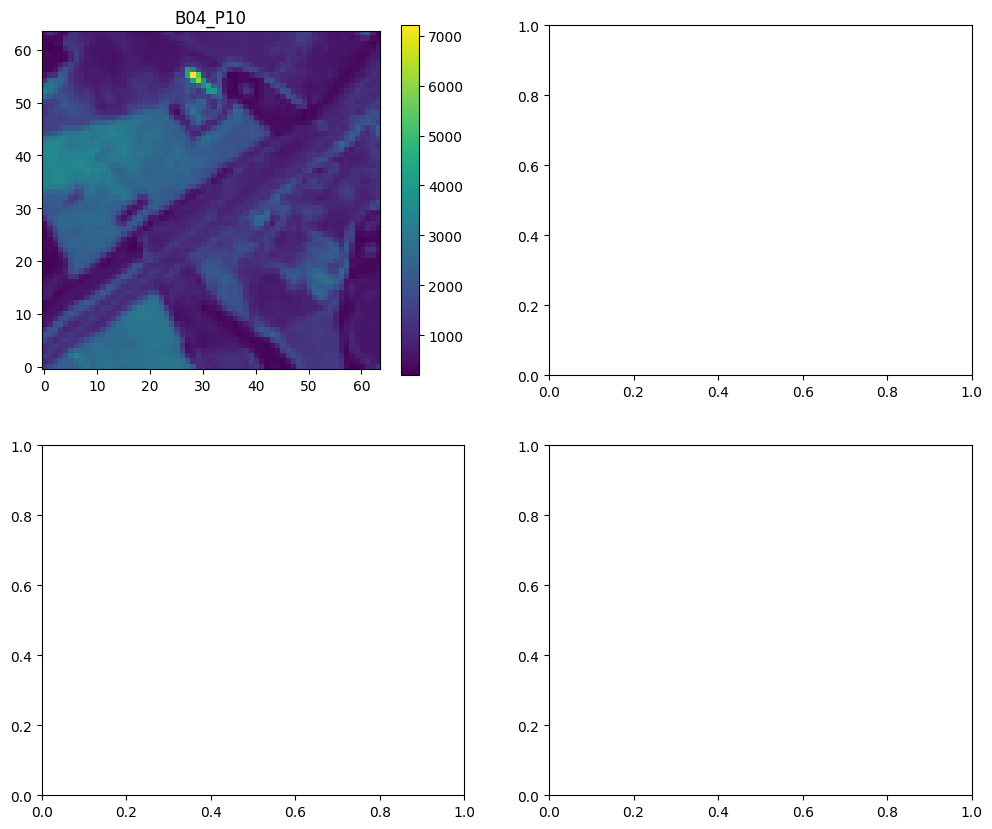

In [8]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
test = xr.open_dataset('test.nc')

# Select a specific time slice for plotting, e.g., the first time point
time_index = 1
b04 = test['B04'].isel(t=time_index)

# Create a figure to plot 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each variable in a different subplot
im1 = axs[0, 0].imshow(b04, cmap='viridis', origin='lower')
axs[0, 0].set_title('B04_P10')
fig.colorbar(im1, ax=axs[0, 0])




TODO:


- Scale up (saving data, improve efficiency, ...)

